In [1]:
%load_ext autoreload
%autoreload 2
import jax
from jax import jit, vmap
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scalable_gps
from scalable_gps import data
from scalable_gps.kernels import RBFKernel
from scalable_gps.models import ExactGPModel, SamplingGPModel

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

/home/shreyaspadhy_gmail_com/.local/lib/python3.8/site-packages/jax/_src/api_util.py:183: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


## generate data

In [2]:
noise_std = 0.5
n_data = 5000

data_train, data_test = data.get_concentrating_toy_sin_dataset(
    seed=3,
    n=n_data,
    noise_scale=noise_std,
    n_test=100,
    normalise=False
)

(-6.0, 6.0)

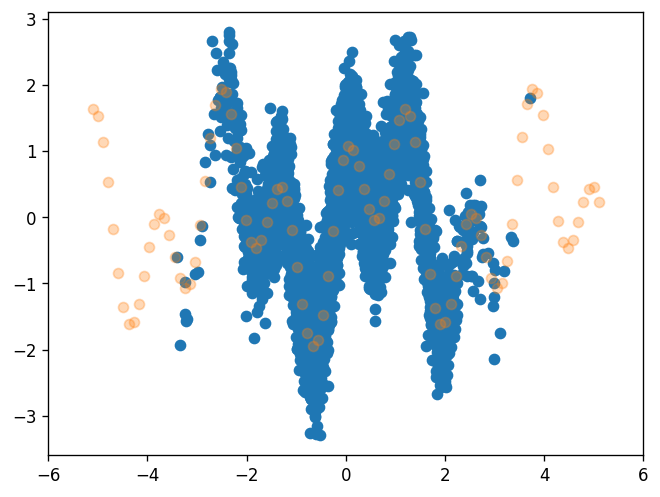

In [3]:
plt.figure(dpi=120)
plt.scatter(data_train.x, data_train.y)
plt.scatter(data_test.x, data_test.y, alpha=0.3)
plt.xlim([-6,6])

## exact gp model

In [4]:
kernel_config = {
    'signal_scale': 2.,
    'length_scale': 0.4,
}

kernel = RBFKernel(kernel_config=kernel_config)

num_features = 2000


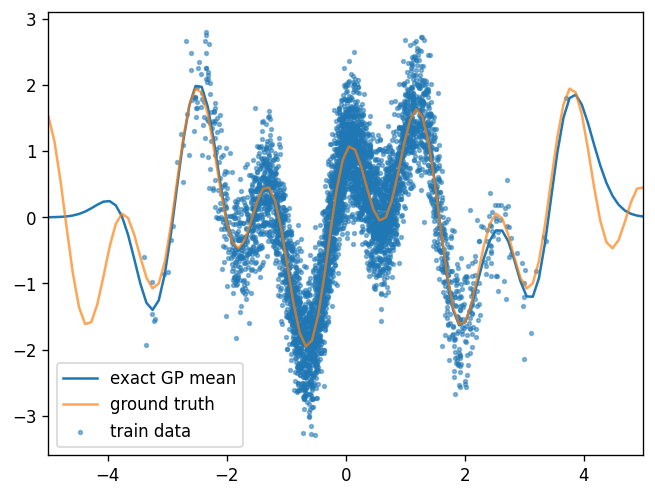

In [5]:
exact_gp = ExactGPModel(noise_scale=noise_std, kernel=kernel)

exact_alphas = exact_gp.compute_representer_weights(data_train)

exact_mean_preds = exact_gp.predictive_mean(data_train, data_test)

plt.figure(dpi=120)
plt.plot(data_test.x, exact_mean_preds, label='exact GP mean')
plt.plot(data_test.x, data_test.y, alpha=0.7, label='ground truth')
plt.scatter(data_train.x, data_train.y, 5, label='train data', alpha=0.5)
plt.xlim([-5, 5])
plt.legend()


### exact GP sample

Traced<ShapedArray(float32[5000])>with<DynamicJaxprTrace(level=2/0)>


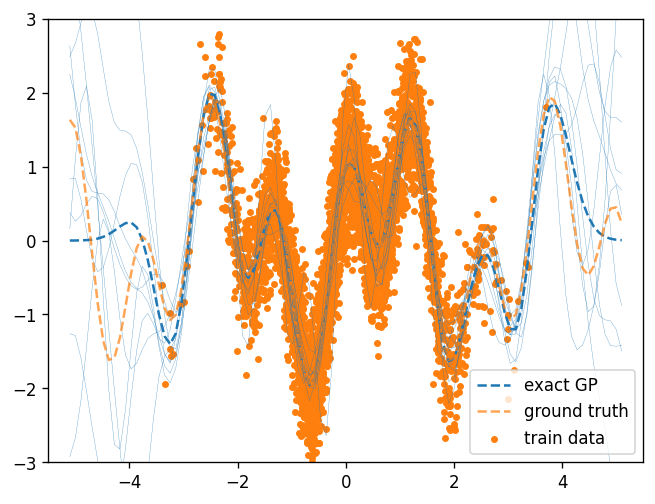

In [6]:

base_key = jax.random.PRNGKey(0)

num_samples = 10

sample_keys = jax.random.split(base_key, num_samples)


alpha_samples, y_pred_samples = jax.vmap(jax.jit(partial(exact_gp.compute_posterior_sample,
                                 train_ds=data_train, test_ds=data_test,
                                 num_features=num_features,
                                 use_rff_features=True,
                                zero_mean=False,
                                 )))(sample_keys)


plt.figure(dpi=120)
plt.plot(data_test.x, exact_mean_preds, label='exact GP', linestyle='--', c=c[0])
plt.plot(data_test.x, y_pred_samples.T, c=c[0], linestyle='-', linewidth=0.2, alpha=0.8)
plt.plot(data_test.x, data_test.y, alpha=0.7, label='ground truth', c=c[1], linestyle='--')
plt.scatter(data_train.x, data_train.y, 10, label='train data', alpha=1, c=c[1])
plt.xlim([-5.5, 5.5])
plt.ylim([-3, 3])
plt.legend()


# SGD GP

In [14]:
import ml_collections
config = ml_collections.ConfigDict()
config.train_config = ml_collections.ConfigDict()

config.train_config.learning_rate = 1e-4
config.train_config.momentum = 0.9
config.train_config.polyak = 1e-3
config.train_config.iterations = int(5e4)
config.train_config.batch_size = 20
config.train_config.eval_every = 100
config.train_config.num_features = 100
config.train_config.num_features = 100
config.train_config.recompute_features = True

sampling_gp = SamplingGPModel(noise_scale=noise_std, kernel=kernel)

optim_key = jax.random.PRNGKey(1)

metrics = ["loss", "alpha_diff", "y_pred_diff", "hilbert_err"]
compare_exact_vals = [exact_alphas, exact_mean_preds, None, None, None ]

alpha_polyak, info = sampling_gp.compute_representer_weights(
            train_ds=data_train, test_ds=data_test,
            config=config.train_config,
            key=optim_key,
            metrics=metrics,
            compare_exact_vals=compare_exact_vals
        )


100%|██████████| 50000/50000 [00:19<00:00, 2512.64it/s]


In [18]:
loss_vec = []
alpha_err_vec = []
pred_err_vec = []
hilbert_err_vec = []

for i in range(len(info)):
    loss_vec.append(info[i]['/loss'])
    alpha_err_vec.append(info[i]['/alpha_diff'])
    pred_err_vec.append(info[i]['/y_pred_diff'])
    hilbert_err_vec.append(info[i]['/hilbert_err'])




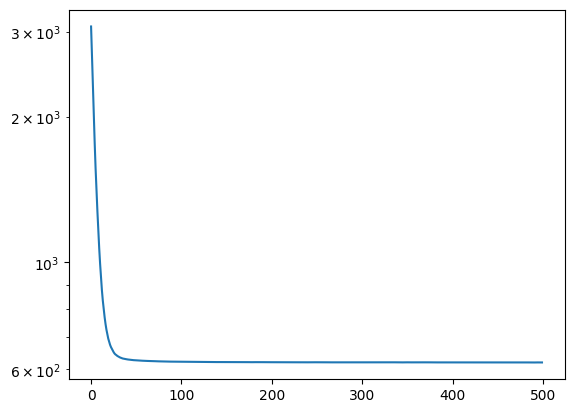

In [16]:
plt.plot(loss_vec)
plt.yscale('log')



### sampling with SGD GP

In [36]:
optim_key = jax.random.PRNGKey(1)

metrics = ["loss",]#, "alpha_diff", "y_pred_diff", "hilbert_err"]
# compare_exact_vals = [exact_alphas, exact_mean_preds, None, None, None ]

base_key = jax.random.PRNGKey(0)
num_samples = 10
sample_keys = jax.random.split(base_key, num_samples)

compute_sample = partial(sampling_gp.compute_posterior_sample, 
                         train_ds=data_train, 
                         test_ds=data_test, 
                         config=config.train_config, 
                         loss_type=2, 
                         metrics=metrics, 
                         metrics_prefix="", 
                         compare_exact_vals=None, 
                         use_chol = False)

SGD_alpha_samples, sample_infos = jax.vmap(jax.jit(compute_sample))(sample_keys)


['loss']


100%|██████████| 50000/50000 [00:47<00:00, 1048.76it/s]


KeyboardInterrupt: 

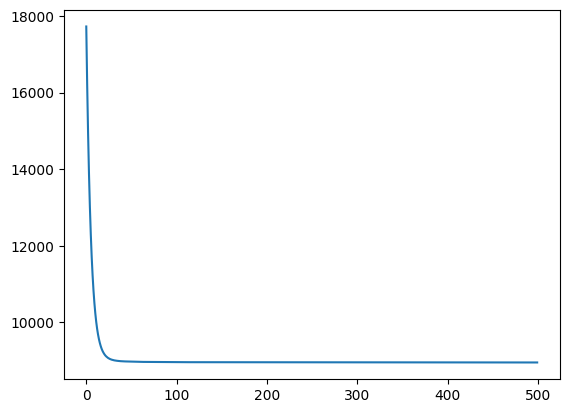

In [33]:
loss_vec = []


for i in range(len(sample_infos)):
    loss_vec.append(jnp.mean(sample_infos[i]['/loss']))
#     alpha_err_vec.append(sample_info[i]['/alpha_diff'])
#     pred_err_vec.append(sample_info[i]['/y_pred_diff'])
#     hilbert_err_vec.append(sample_info[i]['/hilbert_err'])

plt.plot(loss_vec)
# plt.yscale('log')


### There seems to be some missmatch between the exact sample seed and the optimised one

/home/shreyaspadhy_gmail_com/.local/lib/python3.8/site-packages/jax/_src/api_util.py:183: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


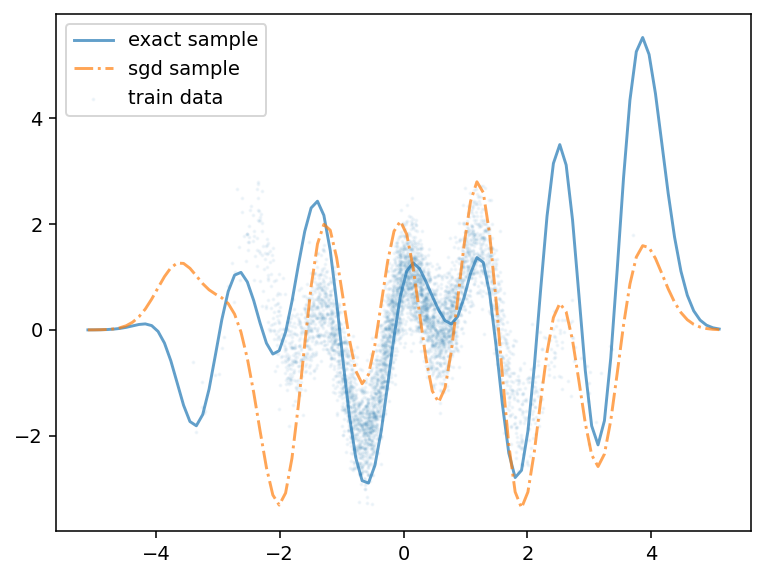

In [34]:
from scalable_gps.linalg_utils import KvP

exact_sample_pred0  = KvP(
            data_test.x, data_train.x, alpha_samples[0], kernel_fn=kernel.K)

SGD_sample_pred0  = KvP(
            data_test.x, data_train.x, SGD_alpha_samples[0] + exact_alphas, kernel_fn=kernel.K)

plt.figure(dpi=140)
plt.plot(data_test.x, exact_sample_pred0, alpha=0.7, label='exact sample')
plt.plot(data_test.x, SGD_sample_pred0, alpha=0.7, label='sgd sample', linestyle='-.')
# plt.plot(data_test.x, cg_preds, alpha=0.7, label='cg sample', linestyle='--')
plt.scatter(data_train.x, data_train.y, 1, label='train data', alpha=0.05)
# plt.xlim([-4, 4])
# plt.ylim([-2.5, 2.5])
plt.legend()

## CG solve

In [50]:
a.shape

(100, 1)

In [52]:
from scalable_gps.linalg_utils import KvP

def gen_closure(kernel, noise_std, data_train):

    def closure(alpha):
        return KvP(data_train.x, data_train.x, alpha, kernel_fn=kernel.K) + alpha * noise_std**2
    
    return jax.jit(closure)

closure = gen_closure(kernel, noise_std, data_train)

In [123]:
@jax.jit
def jit_cg(vector): 
    return jax.scipy.sparse.linalg.cg(closure, vector, tol=1e-02, atol=0.0, maxiter=55, M=None)[0]

vector = data_train.y.squeeze()
cg_alpha = jit_cg(vector)



## compare preds

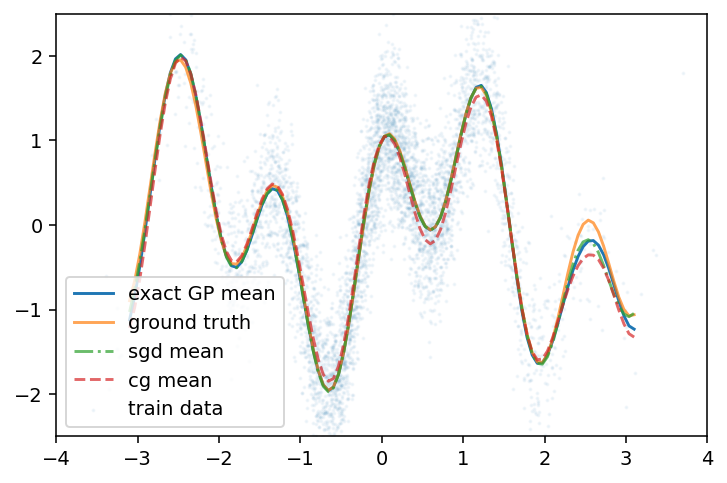

In [122]:
from scalable_gps.linalg_utils import KvP
sgd_preds  = KvP(
            data_test.x, data_train.x, alpha_polyak, kernel_fn=kernel.K)

cg_preds  = KvP(
            data_test.x, data_train.x, cg_alpha, kernel_fn=kernel.K)

plt.figure(dpi=140)
plt.plot(data_test.x, exact_mean_preds, label='exact GP mean')
plt.plot(data_test.x, data_test.y, alpha=0.7, label='ground truth')
plt.plot(data_test.x, sgd_preds, alpha=0.7, label='sgd mean', linestyle='-.')
plt.plot(data_test.x, cg_preds, alpha=0.7, label='cg mean', linestyle='--')
plt.scatter(data_train.x, data_train.y, 1, label='train data', alpha=0.05)
plt.xlim([-4, 4])
plt.ylim([-2.5, 2.5])
plt.legend()


## eval CG over time

In [124]:
from scalable_gps.metrics import RMSE, hilbert_space_RMSE

cg_alpha_err = []
cg_pred_err = []
cg_hilbert_err = []
for i in range(60):
    @jax.jit
    def jit_cg(vector): 
        return jax.scipy.sparse.linalg.cg(closure, vector, tol=1e-03, atol=0.0, maxiter=i, M=None)[0]
    
    vector = data_train.y.squeeze()
    cg_alpha = jit_cg(vector)
    cg_preds  = KvP(
            data_test.x, data_train.x, cg_alpha, kernel_fn=kernel.K)
    
    cg_alpha_err.append(RMSE(exact_alphas, cg_alpha))
    cg_pred_err.append(RMSE(exact_mean_preds, cg_preds))
    cg_hilbert_err.append(hilbert_space_RMSE(exact_alphas, cg_alpha, kernel.K(data_train.x, data_train.x)))
    

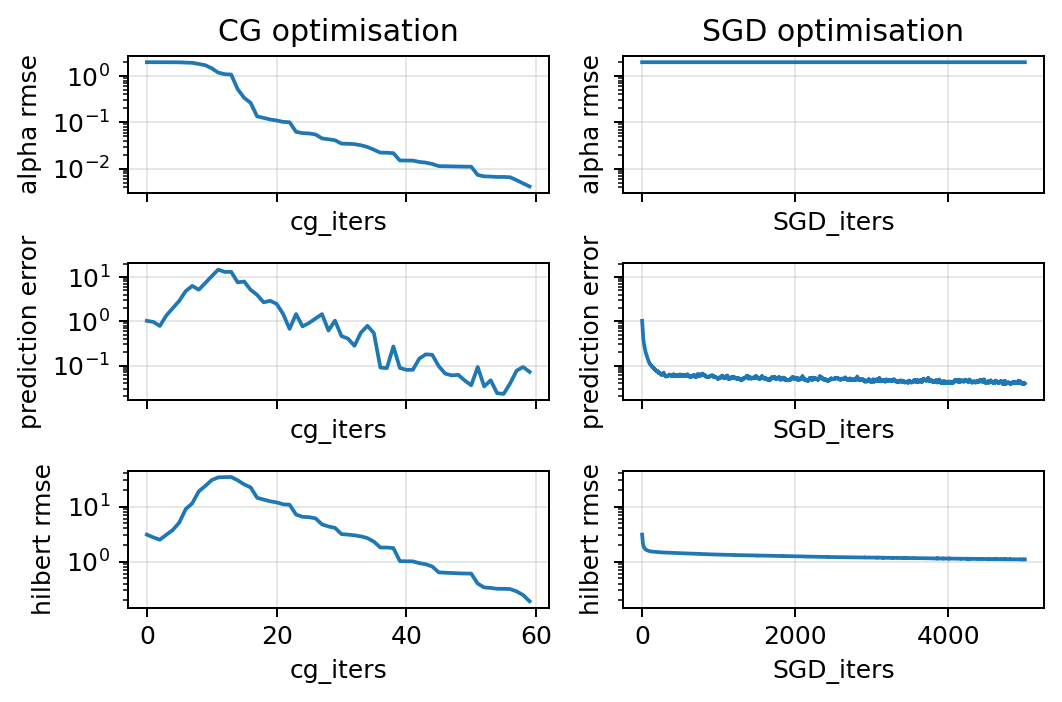

In [125]:
fig, ax = plt.subplots(3,2, dpi=180, sharex='col', sharey='row')

ax[0,0].plot(cg_alpha_err)
ax[0,0].set_xlabel('cg_iters')
ax[0,0].set_ylabel('alpha rmse')
ax[0,0].grid(alpha=0.3)
ax[0,0].set_title('CG optimisation')

ax[1,0].plot(cg_pred_err)
ax[1,0].set_xlabel('cg_iters')
ax[1,0].set_ylabel('prediction error')
ax[1,0].grid(alpha=0.3)

ax[2,0].plot(cg_hilbert_err)
ax[2,0].set_xlabel('cg_iters')
ax[2,0].set_ylabel('hilbert rmse')
ax[2,0].grid(alpha=0.3)

# plt.tight_layout()


# fig, ax = plt.subplots(1,2, dpi=160)

ax[0,1].set_title('SGD optimisation')
ax[0,1].plot(alpha_err_vec)
ax[0,1].set_xlabel('SGD_iters')
ax[0,1].set_ylabel('alpha rmse')
ax[0,1].grid(alpha=0.3)
ax[0,1].set_yscale('log')

ax[1,1].plot(pred_err_vec)
ax[1,1].set_xlabel('SGD_iters')
ax[1,1].set_ylabel('prediction error')
ax[1,1].grid(alpha=0.3)
ax[1,1].set_yscale('log')

ax[2,1].plot(hilbert_err_vec)
ax[2,1].set_xlabel('SGD_iters')
ax[2,1].set_ylabel('hilbert rmse')
ax[2,1].grid(alpha=0.3)
ax[2,1].set_yscale('log')


plt.tight_layout()
